In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects

from scipy.stats import ttest_ind
from scipy.spatial.distance import cdist

from WassersteinTSNE import GaussianDistribution, plotGaussian
from sklearn.decomposition import PCA

import sys
sys.path.insert(0, '../src')

from utils.logger import logger
import utils.visualization as vis
import utils.preprocession as prep

save_figures = []
save_figures.append('../figures')


In [2]:
candidates = pd.read_csv('../data/candidates.csv', index_col=0)
candidate_reactions = pd.read_csv('../data/candidates_reactions.csv', index_col=0)
voters_reactions = pd.read_csv('../data/voters_reactions.csv', index_col=0)
questions = pd.read_csv('../data/questions.csv', index_col=0)
questions.index = questions.index.astype(str)

gpt_data = pd.read_csv('../results/gpt/2023/gpt4_results.csv', index_col=[0,1])
gpt_voters = pd.read_csv('../data/gpt_voters.csv', index_col=0)
true_means = pd.read_csv('../data/party_means.csv', index_col=0)
true_stds = pd.read_csv('../data/party_stds.csv', index_col=0)
true_means.columns.name = 'party'
true_means.index = true_means.index.astype(str)
true_stds.columns.name = 'party'
true_stds.index = true_means.index.astype(str)
gpt_data

32214  32215  32216  32217  32218  32219  32220  32221  \
party  temperature                                                           
EDU    1.0           0.25   0.60   0.00   0.00   0.30   0.25   0.00   0.00   
       1.0           0.00   0.50   0.00   0.00   0.30   0.30   0.00   0.00   
       1.0           0.00   0.50   0.50   0.00   0.00   0.30   0.35   0.00   
       1.0           0.00   0.70   0.00   0.00   0.35   0.30   0.00   0.00   
       1.0           0.50   0.50   0.00   0.00   0.40   0.30   0.00   0.00   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
Übrige 2.0           0.52   0.34   0.99   0.00   0.75   0.20   0.57   0.90   
       2.0           0.60   0.50   0.53   0.50   0.80   0.44   0.50   0.10   
       2.0           0.40   0.60   1.00   0.35   0.60   0.60   0.69   0.85   
       2.0           0.50   0.56   0.50   0.20   0.81   0.50   0.60   0.50   
       2.0           0.67   0.40   0.60   0.00   0.00   0.50   0.46   0.50   

                    32222  32223  ...  32279  32280  32281  32282  32283  \
party  temperature                ...                                      
EDU    1.0           0.40   1.00  ...   0.60   0.30   0.50   0.50   0.50   
       1.0           0.00   1.00  ...   0.50   0.20   0.50   0.50   0.50   
       1.0           0.50   1.00  ...   0.85   0.20   0.30   0.50   0.50   
       1.0           0.30   1.00  ...   0.60   0.35   0.50   0.40   0.50   
       1.0           0.20   0.80  ...   0.60   0.30   0.30   0.40   0.50   
...                   ...    ...  ...    ...    ...    ...    ...    ...   
Übrige 2.0           0.20   0.85  ...   0.20   0.72   0.45   1.00   0.26   
       2.0           0.70   0.85  ...   0.30   0.70   0.65   0.80   0.50   
       2.0           0.50   0.70  ...   0.20   0.50   0.78   0.68   1.00   
       2.0           0.45   1.00  ...   0.30   0.74   0.75   0.70   0.58   
       2.0           0.50   1.00  ...   0.20   0.90   0.50   0.75   0.50   

                    32284  32285  32286  32287  32288  
party  temperature                                     
EDU    1.0           0.50   0.50   0.80   0.70    0.3  
       1.0           0.30   0.85   0.70   0.70    0.3  
       1.0           0.50   0.50   0.80   0.75    0.3  
       1.0           0.50   0.60   1.00   0.50    0.3  
       1.0           0.70   0.70   0.80   0.50    0.3  
...                   ...    ...    ...    ...    ...  
Übrige 2.0           0.65   0.50   0.70   0.50    0.5  
       2.0           0.50   0.65   0.70   0.50    0.5  
       2.0           0.50   0.48   0.50   0.37    0.5  
       2.0           0.65   0.50   0.20   0.50    0.5  
       2.0           0.81   0.50   0.75   0.50    0.2  

[450 rows x 75 columns]

In [4]:
def compute_differences(row):
    ground_truth = true_means.loc[:,row.name]
    return (row - ground_truth).abs().mean()

### Confusion Matrices

In [3]:
def confusion_matrix(matrix, ax=None, vmax=None, shrink=.8):
    if ax is None:
        fig, ax = plt.subplots(figsize=(0.45*vis.textwidth,.45*vis.textwidth))
    else:
        fig = ax.get_figure()

    words = list(vis.party_names.keys())[:-1]
    # Reindex to ensure all eight words appear as rows and columns
    values = matrix.reindex(index=words, columns=words, fill_value=0)
    # print(matrix.sum(axis=1))

    values = pd.DataFrame(prep.normalize_and_round(values),
                          index=words, columns=words)

    # Plotting using matplotlib
    im = ax.imshow(values, cmap='YlGnBu', vmin=0, vmax=100)

    # Add a colorbar
    fig.colorbar(im, ax=ax, shrink=shrink)

    # Set tick marks and labels
    ax.set(xticks=np.arange(len(words)),
           yticks=np.arange(len(words)),
           ylabel=matrix.index.name,
           xlabel=matrix.columns.name)
    ax.set_xticklabels(list(vis.party_names.values())[:-1], rotation=45, ha='right')
    ax.set_yticklabels(list(vis.party_names.values())[:-1], ha='right')

    # Annotate each cell with the numerical value
    for i in range(len(words)):
        for j in range(len(words)):
            text = ax.text(j, i, values.iloc[i, j], ha='center', va='center', color='white')
            if values.iloc[i, j] > 0:
                text.set_path_effects([path_effects.Stroke(linewidth=.5, foreground='black'), path_effects.Normal()])

    return fig, ax

In [4]:
true_dist = pd.DataFrame(cdist(true_means.T,true_means.T),
                         index=true_means.columns, columns=true_means.columns)
true_dist = true_dist.loc[vis.party_names.keys(), vis.party_names.keys()]

In [5]:
def sample_indices(distance_matrix):
    # Convert distances to weights using a softmax-like approach (smaller distances yield higher weights)
    weights = np.exp(-distance_matrix)
    probabilities = weights / np.sum(weights, axis=1, keepdims=True)

    # Compute the cumulative distribution for each row
    cdf = np.cumsum(probabilities, axis=1)

    # Generate a uniform random number for each row (shape: (8, 1))
    random_values = np.random.rand(probabilities.shape[0], 1)

    # For each row, find the first index where the cumulative probability exceeds the random value.
    # This is fully vectorized.
    sampled_indices =  (cdf >= random_values).argmax(axis=1)
    gpt_parties = pd.DataFrame([gpt_data.index.get_level_values(0).values,true_means.columns[sampled_indices].values], index=('GPT Prompt', 'Closest Party-Mean')).T
    return pd.crosstab(gpt_parties.iloc[:,0], gpt_parties.iloc[:,1])

# Compute the pairwise distances between each row in dataset1 and each row in dataset2
distance_matrix = cdist(gpt_data.fillna(0.5), true_means.drop('Übrige', axis=1).T, 'cityblock')

# Sample the indices of the closest party for each GPT prompt
gpt_parties = []
for i in range(1000):
    gpt_parties.append(sample_indices(distance_matrix))
gpt_parties_mean =  pd.concat(gpt_parties).groupby(level=0).mean()
gpt_parties_stds =  pd.concat(gpt_parties).groupby(level=0).std()
gpt_parties_stds.round(2)

Closest Party-Mean,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP
GPT Prompt,,,,,,,,
EDU,1.10,0.00,0.00,0.00,0.00,0.05,0.00,1.10
EVP,0.03,1.75,0.00,0.97,0.80,1.17,0.47,0.00
FDP,0.56,0.11,2.08,0.72,0.00,1.93,0.00,0.45
GLP,0.00,1.28,0.00,1.50,0.32,0.72,0.22,0.00
Grüne,0.00,0.06,0.00,0.08,2.90,0.00,2.90,0.00
Mitte,0.00,3.36,0.00,3.16,0.26,2.64,0.16,0.00
SP,0.00,0.15,0.00,0.13,3.31,0.00,3.31,0.00
SVP,1.29,0.00,0.10,0.00,0.00,0.00,0.00,1.30
Übrige,1.23,2.24,0.31,2.24,0.10,2.96,0.04,0.23


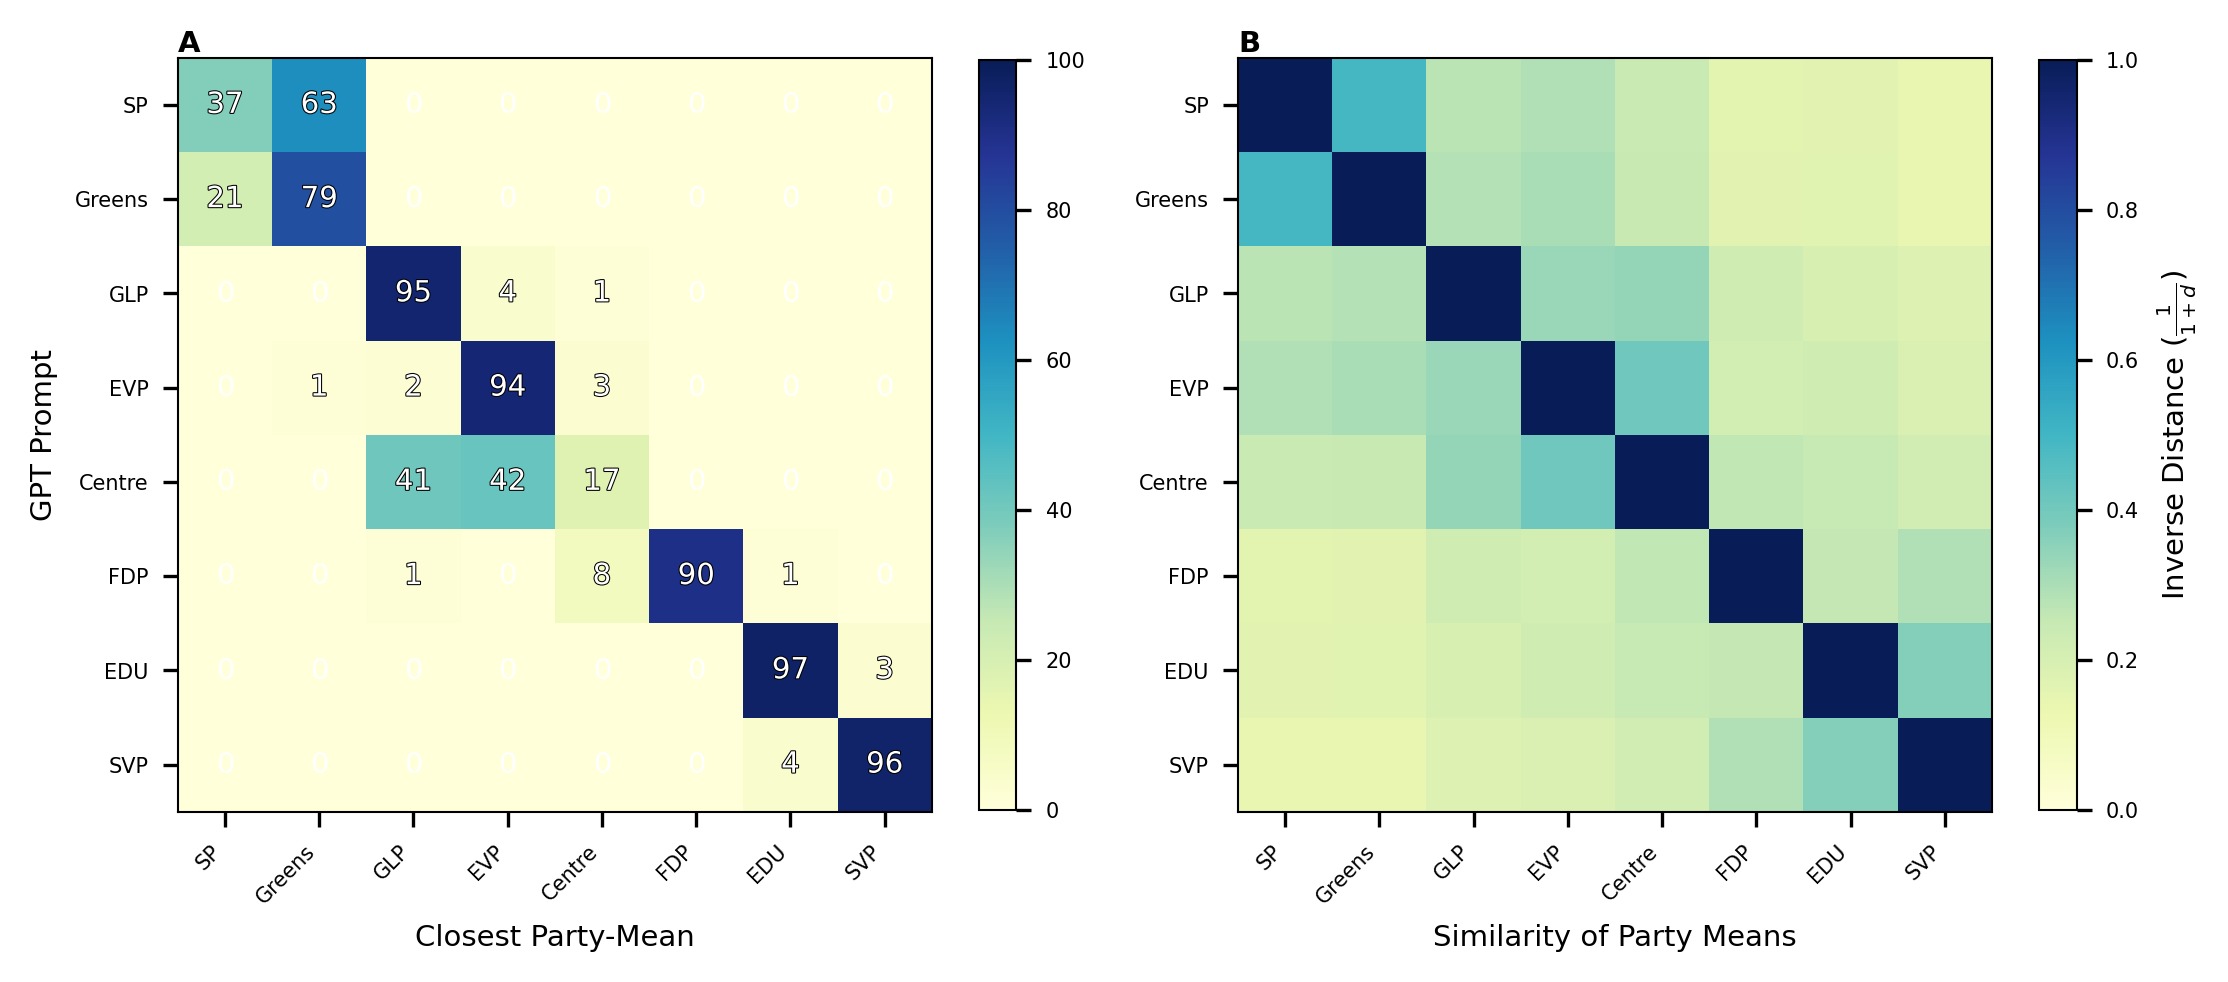

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.textwidth,.45*vis.textwidth))
true_dist = pd.DataFrame(cdist(true_means.T,true_means.T),
                         index=true_means.columns, columns=true_means.columns)
true_dist = 1/(1+true_dist.loc[list(vis.party_names.keys())[:-1], list(vis.party_names.keys())[:-1]])
fig, ax1 = confusion_matrix(gpt_parties_mean, ax=ax1, shrink=.85) 
colorbar = ax2.imshow(true_dist, cmap='YlGnBu',vmin=0, vmax=1)
fig.colorbar(colorbar, ax=ax2, shrink=.85, label=r'Inverse Distance ($\frac{1}{1+d}$)')
ax2.set_xticks(np.arange(len(true_dist.columns)))
ax2.set_yticks(np.arange(len(true_dist.index)))
ax2.set_xticklabels(list(vis.party_names.values())[:-1], rotation=45, ha='right')
ax2.set_yticklabels(list(vis.party_names.values())[:-1], ha='right')
ax2.set_xlabel('Similarity of Party Means')
fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)
fig.tight_layout()
vis.savefig(fig, 'ClosestParty_GPT', save_figures)

In [7]:
# Compute the pairwise distances between each row in dataset1 and each row in dataset2
means = gpt_data.groupby(level=0).mean().drop('Übrige')

distance_matrix = cdist(candidate_reactions, means, 'cityblock')

# For each row in dataset1, find the index of the closest row in dataset2
closest_indices = np.argmin(distance_matrix, axis=1)

print("Indices of closest rows in dataset2 for each row in dataset1:")
candidates_gpt = pd.DataFrame([candidates['list'].values,means.iloc[closest_indices].index.values], index=('Candidates', 'Closest GPT-Mean')).T
candidates_gpt

Indices of closest rows in dataset2 for each row in dataset1:


,Candidates,Closest GPT-Mean
0,FDP,FDP
1,GLP,EDU
2,EVP,Mitte
3,Übrige,Grüne
4,SP,Grüne
...,...,...
1024,SVP,SVP
1025,Mitte,FDP
1026,Mitte,Mitte
1027,Grüne,Grüne


In [8]:
# Compute the pairwise distances between each row in dataset1 and each row in dataset2
distance_matrix = cdist(candidate_reactions.values, true_means.drop('Übrige', axis=1).T.values, 'cityblock')

# For each row in dataset1, find the index of the closest row in dataset2
closest_indices = np.argmin(distance_matrix, axis=1)

print("Indices of closest rows in dataset2 for each row in dataset1:")
candidate_parties = pd.DataFrame([candidates.list.values,true_means.columns[closest_indices].values], index=('Candidates', 'Closest Party-Mean')).T
candidate_parties

Indices of closest rows in dataset2 for each row in dataset1:


,Candidates,Closest Party-Mean
0,FDP,FDP
1,GLP,EDU
2,EVP,Mitte
3,Übrige,Grüne
4,SP,SP
...,...,...
1024,SVP,SVP
1025,Mitte,FDP
1026,Mitte,Mitte
1027,Grüne,Grüne


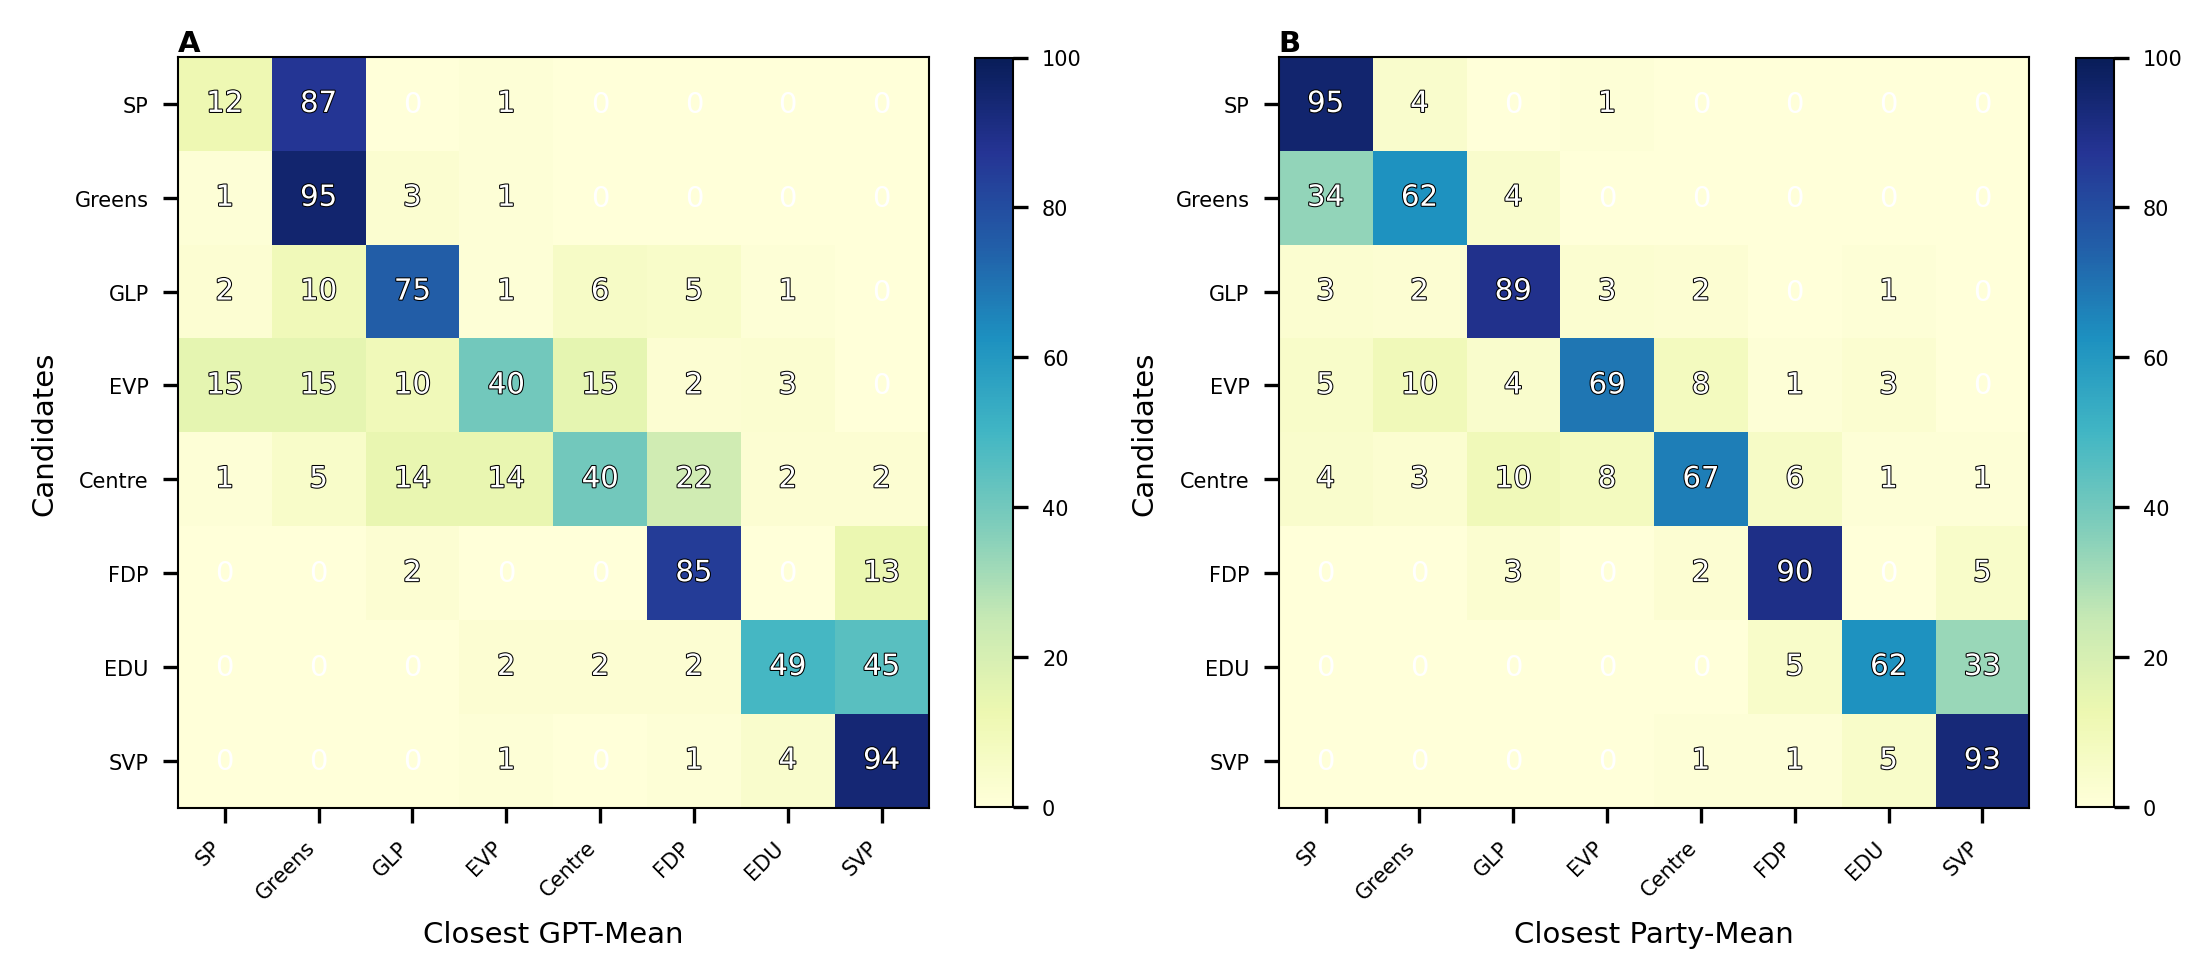

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.textwidth,.45*vis.textwidth))
vmax = max(candidate_parties.value_counts().max(), candidates_gpt.value_counts().max())
shrink = 0.85
fig, ax1 = confusion_matrix(pd.crosstab(candidates_gpt.iloc[:,0], candidates_gpt.iloc[:,1]), ax=ax1,  shrink=shrink) 
fig, ax2 = confusion_matrix(pd.crosstab(candidate_parties.iloc[:,0], candidate_parties.iloc[:,1]), ax=ax2,  shrink=shrink)
fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)
fig.tight_layout()
vis.savefig(fig, 'ClosestParty_Candidates', save_figures)

### GPT Temperature

In [18]:
data = gpt_data.loc[gpt_data.index.get_level_values(0)!='Übrige']             
var = data.groupby(level=[0,1]).std().mean(axis=1).groupby(level=1).mean()
nan = data.isna().sum(axis=1).groupby(level=1).sum()

gpt_distribution = data.droplevel(1).apply(compute_differences, axis=1)
gpt_distribution.index=data.index
means = gpt_distribution.groupby(level=1).mean()
means

temperature
1.00    0.160328
1.25    0.163364
1.50    0.165202
1.75    0.170222
2.00    0.167248
dtype: float64

In [19]:
temperature = pd.concat([means, var, nan], axis=1)
temperature.columns=[ 'Mean Distance', 'Response Variance', 'Missing Values']
print(temperature.mean().values)
print(np.round(temperature['Missing Values'].values/75/9*10,2))
print(28.6/9*10/75)
temperature


[ 0.16527299  0.09767293 21.8       ]
[0.   0.01 0.   0.19 1.41]
0.4237037037037037


,Mean Distance,Response Variance,Missing Values
temperature,,,
1.00,0.160328,0.076066,0
1.25,0.163364,0.088140,1
1.50,0.165202,0.100397,0
1.75,0.170222,0.108060,13
2.00,0.167248,0.115702,95


### GPT Accuracy

In [ ]:
gpt_distribution = gpt_data.droplevel(1).loc[gpt_data.index.get_level_values(0) != 'Übrige'].apply(compute_differences, axis=1)
can_distribution = candidate_reactions.loc[candidates.list != 'Übrige']#.apply(compute_differences, axis=1)
can_distribution.index=candidates.loc[candidates.list != 'Übrige', 'list']
can_distribution = can_distribution.apply(compute_differences, axis=1)

In [47]:
gpt_distribution.mean(), gpt_distribution.std(), can_distribution.mean(), can_distribution.std()

(0.1652729881790601,
 0.03210860044903028,
 0.1860846568344533,
 0.06802862497768444)

In [48]:
t_stat, p_value = ttest_ind(gpt_distribution, can_distribution, equal_var=False, alternative='less')
p_value

1.7000299076208246e-13

In [49]:
# Combine the two distributions into a dictionary of results
results = []

# Get the unique groups (parties/lists) that appear in both indices
unique_groups = set(gpt_distribution.index).intersection(set(can_distribution.index))
# unique_groups.remove('Übrige')

# Perform Welch's t-test for each unique group
for group in unique_groups:
    gpt_group = gpt_distribution[gpt_distribution.index == group]
    can_group = can_distribution[can_distribution.index == group]

    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(gpt_group, can_group, equal_var=False, alternative='less')

    # Append the results
    results.append({
        "Party": group,
        "T-statistic": t_stat,
        "P-value": p_value
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results).set_index('Party')
results_df

,T-statistic,P-value
Party,,
FDP,0.627604,7.338107e-01
EDU,-6.447014,1.595739e-08
EVP,-8.314435,1.540268e-13
Grüne,-5.838972,1.993063e-08
SP,6.319840,1.000000e+00
GLP,-4.666153,2.957714e-06
SVP,-9.396310,1.229383e-16
Mitte,-8.915639,3.386544e-16


In [24]:
results_df['GPT-4 Distance'] = gpt_distribution.groupby(level=0).mean()
results_df['GPT-4 Std.'] = gpt_distribution.groupby(level=0).std()
results_df['Candidate Distance'] = can_distribution.groupby(level=0).mean()
results_df['Candidate Std.'] = can_distribution.groupby(level=0).std()
# mean_stds  = true_stds.mean().loc[true_stds.columns != 'Übrige'].mean()
# print('Avergae STD:', mean_stds, 'Candidates Distance:', mean_stds*np.sqrt(2/np.pi), 'GPT-4 Distance:', (true_means - gpt_means).abs().mean().mean())
# results_df.sort_values(by='GPT-4 Distance').plot.bar(rot=0, xlabel='', figsize=(vis.columnwidth, 0.5*vis.columnwidth))
# vis.savefig(plt.gcf(), 'GPT_Mean_Distance', save_figures)
results_df["P-value"] =  pd.to_numeric(results_df['P-value'], errors='coerce')
results_df["P-value"] = results_df['P-value'].map(lambda x: f"{x:.2e}{'*' if x <0.05 else ''}")
cols = [c for c in results_df.columns if c not in ['P-value', 'T-statistic']]
cols.append('P-value')
results_df = results_df[cols]
results_df.sort_values(by='Party')

,GPT-4 Distance,GPT-4 Std.,Candidate Distance,Candidate Std.,P-value
Party,,,,,
EDU,0.197019,0.014367,0.237467,0.039819,1.60e-08*
EVP,0.183900,0.011794,0.232233,0.053703,1.54e-13*
FDP,0.195323,0.010351,0.191278,0.049424,7.34e-01
GLP,0.159652,0.011015,0.181728,0.055257,2.96e-06*
Grüne,0.112386,0.010649,0.142805,0.052781,1.99e-08*
Mitte,0.193416,0.011192,0.239198,0.059227,3.39e-16*
SP,0.136365,0.010529,0.112308,0.040704,1.00e+00
SVP,0.144125,0.012804,0.193067,0.050282,1.23e-16*


### GPT Estimates

In [4]:
gpt_means = gpt_data.groupby(level=0).mean().T
gpt_stds = gpt_data.groupby(level=0).std().T
gpt_means

party,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
32214,0.209400,0.274400,0.760208,0.698600,0.1390,0.545000,0.129000,0.768750,0.482400
32215,0.482800,0.803200,0.352000,0.672653,0.9040,0.755800,0.970000,0.241000,0.554000
32216,0.189796,0.440408,0.620000,0.504600,0.7246,0.494800,0.780204,0.239000,0.569796
32217,0.018000,0.162400,0.760400,0.676200,0.0560,0.534400,0.009000,0.267000,0.305000
32218,0.256531,0.883400,0.424000,0.865000,1.0000,0.794000,0.998000,0.215600,0.711000
...,...,...,...,...,...,...,...,...,...
32284,0.466600,0.767400,0.498000,0.757000,0.9510,0.743878,0.891000,0.297400,0.594400
32285,0.549400,0.334800,0.573000,0.309000,0.1400,0.481020,0.219600,0.796939,0.507755
32286,0.770204,0.581200,0.578600,0.509000,0.3444,0.582000,0.458400,0.843000,0.555000
32287,0.655000,0.337000,0.528000,0.319600,0.1760,0.441000,0.239000,0.815400,0.480400


In [5]:
factor = 1
stats_gpt = (gpt_means > (true_means-factor*true_stds)) & (gpt_means < (true_means+factor*true_stds))
stats_gpt = stats_gpt.mean(axis=0)
stats_gpt.mean()

0.8533333333333333

In [6]:
diff = (true_means - gpt_means).abs()/(true_stds+.1)
max_val = diff['SVP'].max().max()
max_idx = diff.eq(max_val).stack()[lambda x: x].index.tolist()
print("Maximum value:", max_val)
print("Indices of maximum value:", max_idx)
print(questions.loc[max_idx[0][0], 'question_EN'])
min_val = diff['Grüne'].min().min()
min_idx = diff.eq(min_val).stack()[lambda x: x].index.tolist()
print("Minimum value:", min_val)
print("Indices of minimum value:", min_idx)
print(questions.loc[min_idx[0][0], 'question_EN'])

Maximum value: 1.3528318258332448
Indices of maximum value: [('32253', 'SVP')]
Should direct payments only be granted to farmers with proof of ecological performance?
Minimum value: 0.004281056304196474
Indices of minimum value: [('32238', 'Grüne')]
Would you support the introduction of a national inheritance tax on all inheritances over one million Swiss francs?


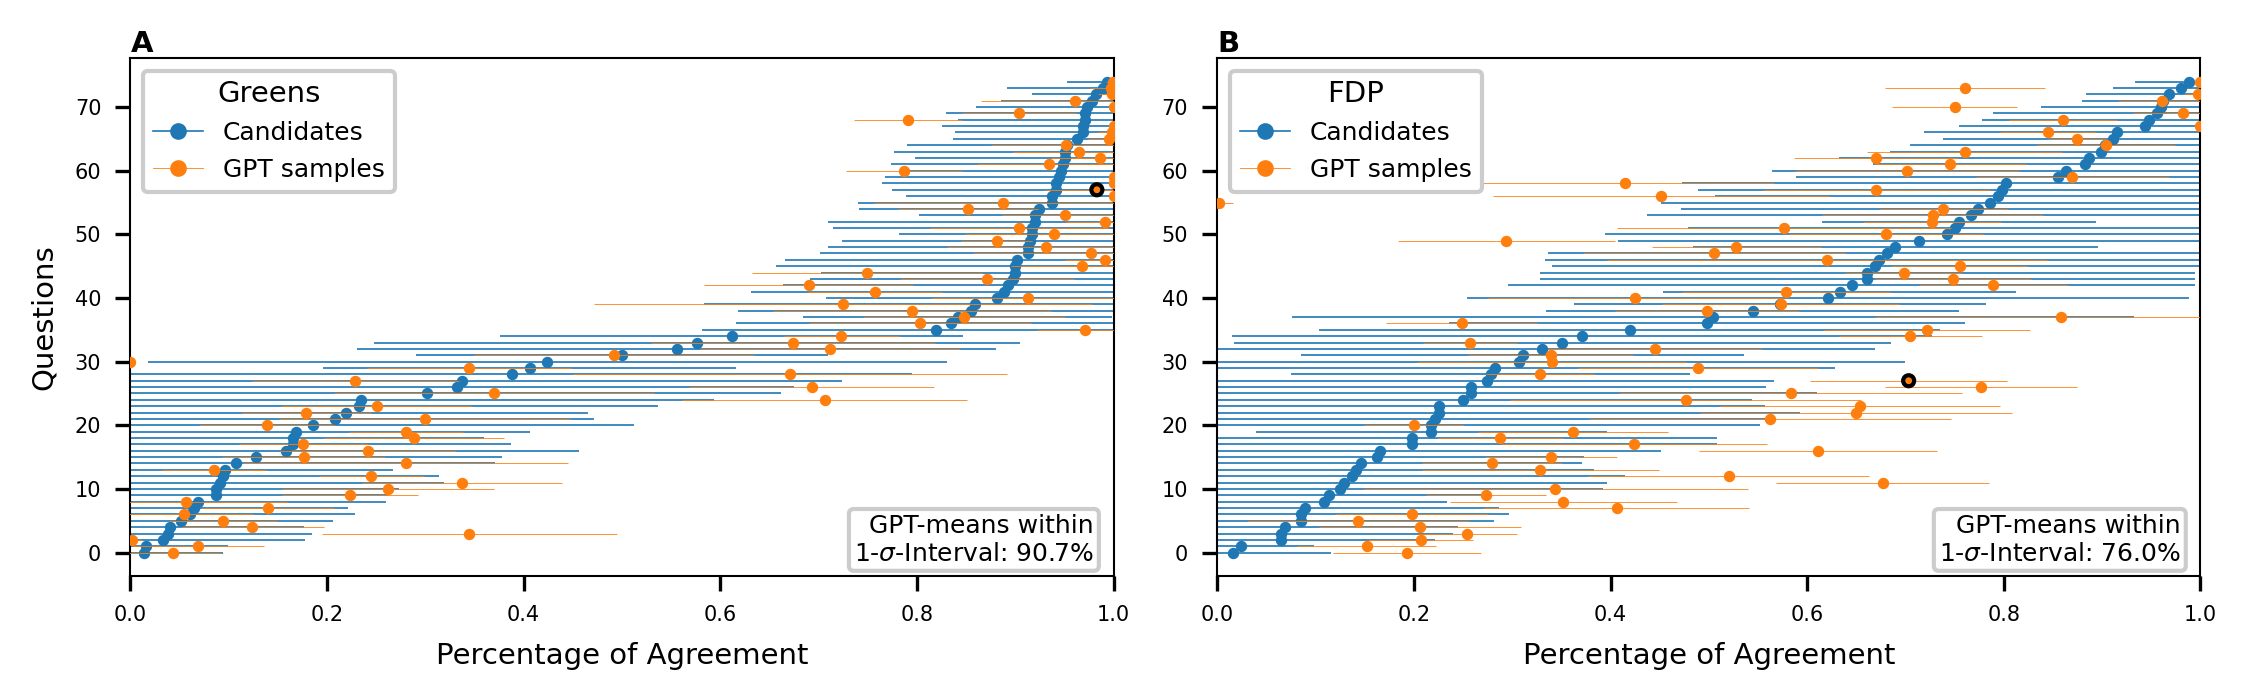

In [12]:
parties = ('Grüne', 'FDP')

def plot_comparison(party, ax=None, indices=[]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(0.5*vis.textwidth, 615*vis.inches_pt/4))
    else:
        fig = ax.get_figure()

    y_positions = range(len(true_means.loc[:,party]))

    means = true_means.loc[:,party].sort_values()
    stds = true_stds.loc[means.index,party]
    estimates = gpt_means.loc[means.index,party]
    errors = gpt_stds.loc[means.index,party]

    # Plotting the estimates as scatter
    for idx in indices:
        ax.scatter(estimates[idx], means.index.get_loc(idx), s=7, lw=1, facecolor='None', edgecolors='black', zorder=4)
    ax.scatter(estimates, y_positions, s=3, color='C1', label='GPT Sample Mean', zorder=3)
    ax.errorbar(estimates, y_positions, xerr=errors, elinewidth=0.2, fmt='None', color='C1', zorder=3, label='Standard Deviation',)

    # Plotting the means with std as horizontal error bars
    ax.scatter(means, y_positions, s=3, label=f"{vis.party_names[party]}-Candidates", color='C0')
    ax.errorbar(means, y_positions, xerr=stds, elinewidth=0.4, fmt='None', label='Standard Deviation', color='C0')

    # Adding labels and title
    ax.set(xlabel='Percentage of Agreement',
            ylabel='Questions',
            # title=f'Mean, STD, and Estimates: {party}',
            xlim=(0,1)
    )
    # plt.yticks(x_positions)  # Set x-ticks to match the positions
    # Adding legend to distinguish between the two types of plots

    # Creating custom legend handles
    legend_elements = [
        Line2D([0], [0], color='C0', lw=.4, label='Candidates', marker='o', markersize=3),
        Line2D([0], [0], color='C1', lw=.2, label='GPT samples', marker='o', markersize=3)
                ]
    leg = ax.legend(handles=legend_elements,facecolor='w', title=vis.party_names[party], loc='upper left')
    leg.get_frame().set_alpha(1)  
    legend_frame = leg.get_frame()

    # Now add a text box that mimics the legend's style.
    ax.text(0.98, 0.02, f"GPT-means within\n1-$\sigma$-Interval: {100*stats_gpt[party]:.1f}%", color='black', fontsize=6,
            transform=ax.transAxes, ha="right", va="bottom", 
            bbox=dict(facecolor=legend_frame.get_facecolor(), edgecolor= legend_frame.get_edgecolor(), boxstyle='round,pad=0.2', alpha=1))
    return fig, ax

fig, axes = plt.subplots(1, 2, figsize=(vis.textwidth, 0.3*vis.textwidth))

for party, ax in zip(parties, axes):
    # The x positions for the plot
    fig, ax = plot_comparison(party, ax, indices=[max_idx[0][0]])

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=axes[0].transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=axes[1].transAxes)
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
fig.tight_layout()

vis.savefig(fig, f'GPT_Comparison_{vis.party_names[parties[0]]}_{vis.party_names[parties[1]]}', save_figures)


In [10]:
for party in list(vis.party_names.keys())[:-1]:
    fig, ax = plot_comparison(party, indices=[max_idx[0][0]])
    fig.tight_layout()
    vis.savefig(fig, f'GPT_Estimates_{vis.party_names[party]}', save_figures)
    plt.close('all')

### Statistical Model

In [3]:
import pickle 
with open('../results/xplore/xplore.pickle', 'rb') as file:
    xplore = pickle.load(file)
xplore.items

,beta1,beta2,alpha
32214,1.617838,3.421553,-0.418051
32215,-3.599476,-1.281332,0.446724
32216,-0.647695,-0.816033,1.080903
32217,1.951557,3.968032,-0.153674
32218,-4.754032,-0.321055,0.356404
...,...,...,...
32284,-1.773229,-0.095368,0.574069
32285,1.830637,-0.259153,-0.416285
32286,0.702293,0.037892,0.197040
32287,1.981198,0.545581,0.154736


Figure size in inches: [542.025 195.129]
Aspect ratio of the figure: 0.36
Do you support an increase in the retirement age (e.g., to 67)?


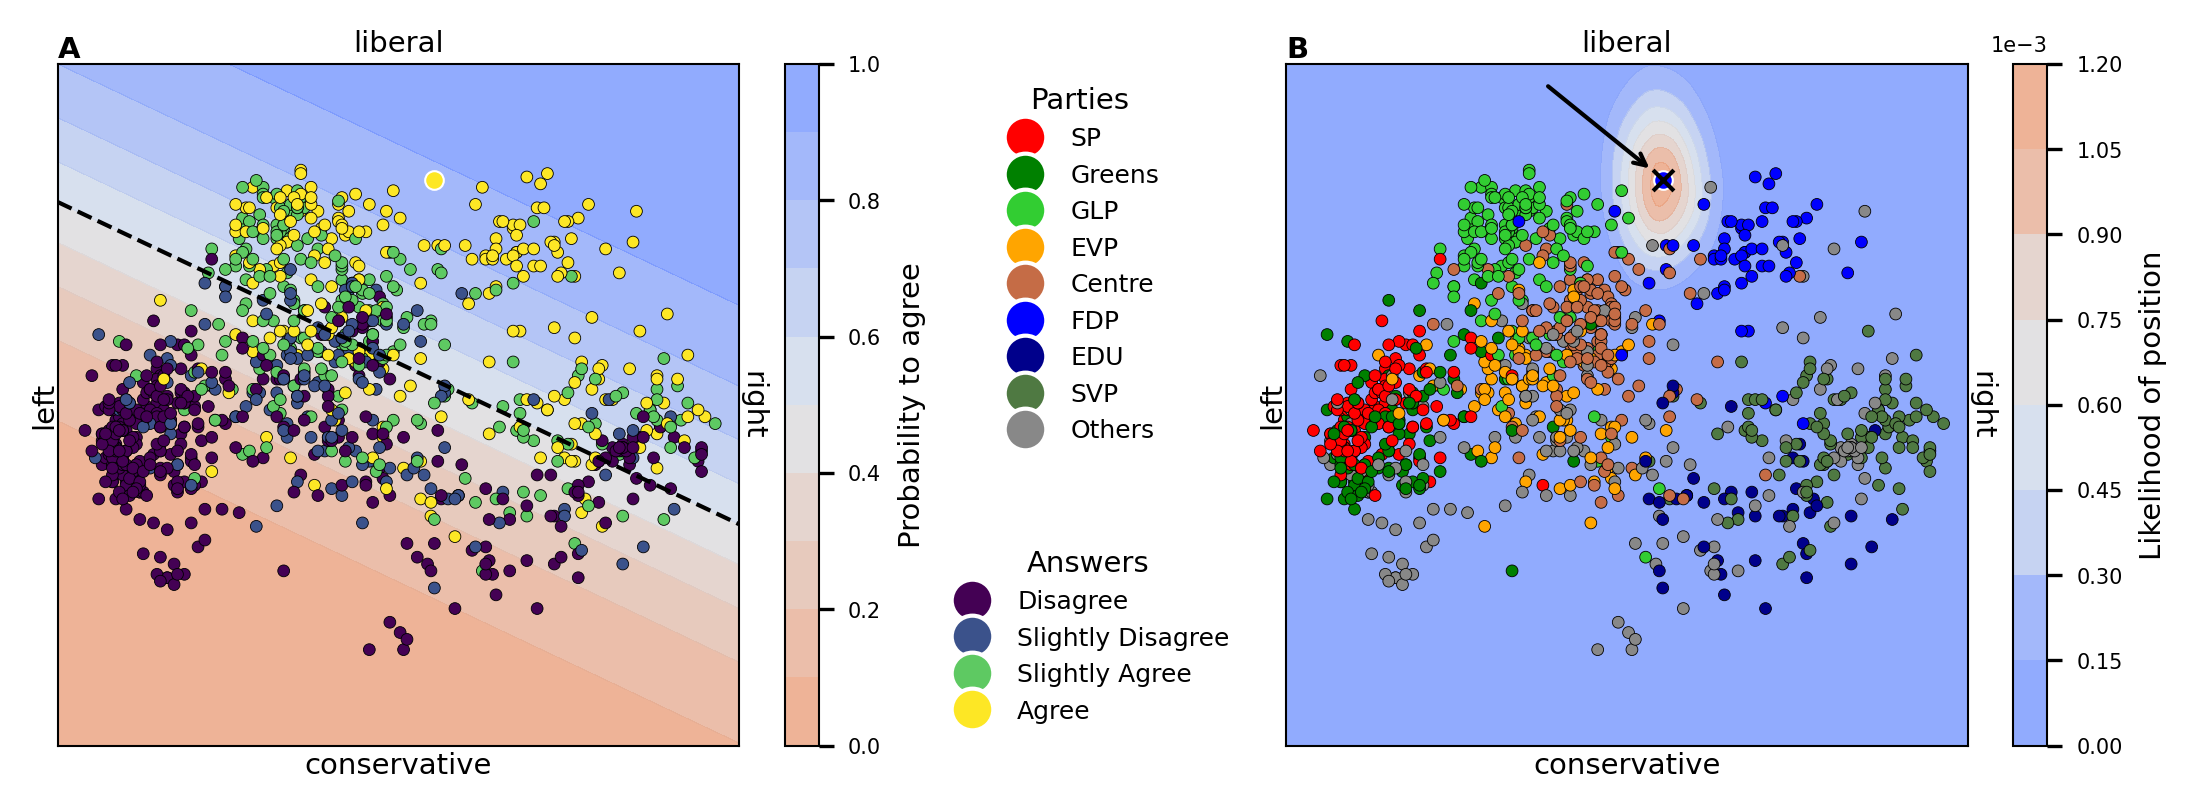

In [4]:
n = xplore.fit_reactions.index[0]
q = '32214'
# q = '32253'
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(vis.textwidth,.36*vis.textwidth))

train_colors = xplore.fit_index.map(candidates.color.to_dict())
vis.plotEmbedding(xplore.embedding, n=n, c=train_colors, s=8,
                    ax=ax2, highlight={'color':train_colors.loc[n], 's':20})

user = xplore.fit_reactions.loc[n]
# user.loc[:] = np.NaN
answers = user.loc[~user.isna()]
vis.plotObjective(xplore.posterior, answers, d=0, r=xplore.r, area=xplore.area, ax=ax2, clabel='Likelihood of position')

x, y = xplore.embed(answers)
ax2.scatter(x, y, marker='x', color='black', s=25, lw=1, zorder=5)
ax2.annotate("", xy=(x-.02,y+.02), xytext=(-.25,.95),
            arrowprops=dict(arrowstyle="->"))

rgba = vis.colormap(user.astype(float).loc[str(q)])
vis.plotEmbedding(xplore.embedding, n=n, highlight={'color':rgba, 's':20},
                c=xplore.fit_reactions.loc[:,str(q)], ax=ax1, s=8)
vis.plotFeature(xplore.predict, q, d=0, r=xplore.r, area=xplore.area, ax=ax1, clabel='Probability to agree')
# _ = ax2.set_title(f'Probabilities for Feature {q}')

# Access the colormap
cmap = plt.cm.viridis
# Specify the values to extract colors for
values = [0.0, 0.25, 0.75, 1.0]
# Extract colors for these values
sentiment_colors = [cmap(val) for val in values]
# Map these colors to the sentiments
sentiments = ['Disagree', 'Slightly Disagree', 'Slightly Agree', 'Agree']
sentiment_color_map = dict(zip(sentiments, sentiment_colors))

# Party colors
legend_elements_1 = [Line2D([0], [0], marker='o', color='w', label=val, markersize=10, markerfacecolor=vis.party_colors[key]) for key, val in vis.party_names.items()]
# Sentiment colors
legend_elements_2 = [Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=val) for key, val in sentiment_color_map.items()]

# Creating the legend with two columns
ax1.legend(handles=legend_elements_1, loc='upper left', bbox_to_anchor=(1.35, 1), title='Parties', ncol=1, frameon=False)
ax2.legend(handles=legend_elements_2, loc='lower right', bbox_to_anchor=(-.05,0), title='Answers', ncol=1, frameon=False)

ticks = []#[-1,-.5, 0, .5, 1]
for ax in (ax1, ax2):
    ax.set(xticks=ticks, yticks=ticks)
    # Add text annotations
    ax.text(-0.02, 0.5, 'left', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
    ax.text(1.02, 0.5, 'right', va='center', ha='center', rotation=270, transform=ax.transAxes)
    ax.text(0.5, 1.03, 'liberal', va='center', ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.03, 'conservative', va='center', ha='center', transform=ax.transAxes)


fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

fig.tight_layout()
plt.subplots_adjust(wspace=.35)
vis.savefig(fig, 'XPLORE_Candidates_32214', save_figures)


# Print the size of the figure
print("Figure size in inches:", fig.get_size_inches()/vis.inches_pt)
print("Aspect ratio of the figure:", fig.get_figheight()/fig.get_figwidth())
print(questions.loc[q, 'question_EN'])

In [6]:
fit_predictions = xplore.predict(xplore.embedding.values)
fit_predictions = pd.DataFrame(fit_predictions, index=xplore.fit_reactions.index, columns=xplore.fit_reactions.columns)
fit_rmse = np.sqrt(np.mean(np.square((xplore.fit_reactions - fit_predictions)), axis=1))

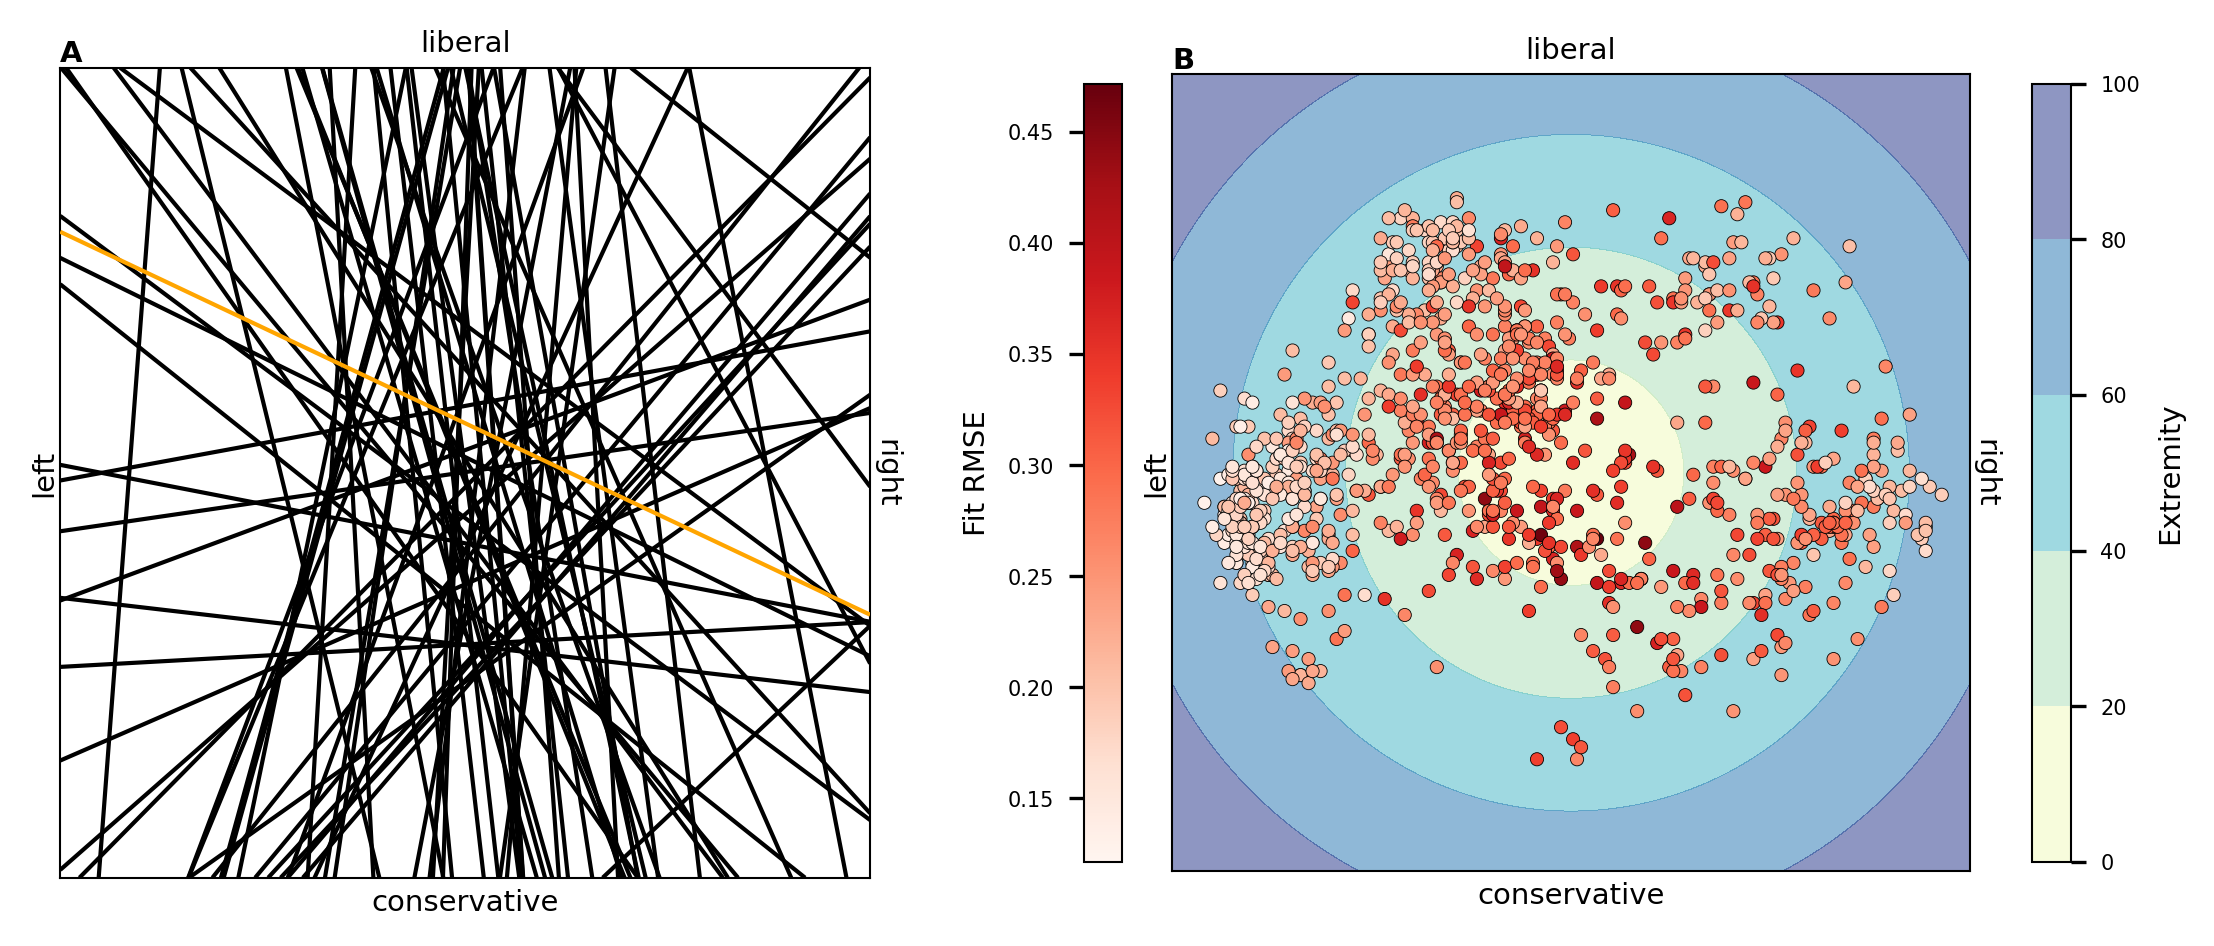

In [21]:
from matplotlib.gridspec import GridSpec

# Create a meshgrid for plotting decision boundaries
x_min, x_max = -1, 1
y_min, y_max = -1, 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Create a figure
fig = plt.figure(figsize=(vis.textwidth, 0.4*vis.textwidth))
gs = GridSpec(1, 2, width_ratios=[.65, 1])  

# Create subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Plot decision boundaries for each model
for index, row in xplore.items.iterrows():
    beta1, beta2, alpha = row['beta1'], row['beta2'], row['alpha']
    zz = beta1 * xx + beta2 * yy + alpha
    color = 'black' if index != q else 'orange'
    zorder = 5 if index != q else 6
    ax1.contour(xx, yy, zz, levels=[0], linewidths=1, zorder=zorder, colors=color)

contourf = ax2.contourf(xx, yy, np.sqrt(xx**2+yy**2)*100/np.sqrt(2), cmap='YlGnBu', levels=np.linspace(0, 100, 6), alpha=0.5)
params = {'zorder':2, 'edgecolors':'black', 's':10, 'linewidths':0.2}
sc = ax2.scatter(xplore.embedding.iloc[:, 0], xplore.embedding.iloc[:, 1], 
                 c=fit_rmse, cmap='Reds', **params)
colorbar = fig.colorbar(contourf, ax=ax2, label='Extremity', shrink=.93)
cb = fig.colorbar(sc, ax=ax2, label='Fit RMSE', location='left', shrink=.93, pad=0.05)

# Set plot limits and labels
ax1.set(xlim=(x_min, x_max),
       ylim=(y_min, y_max),
       aspect='equal',
)

ax2.set(xlim=(x_min, x_max),
       ylim=(y_min, y_max),
       aspect='equal',
)

ticks = []#[-1,-.5, 0, .5, 1]
for ax in (ax1, ax2):
    ax.set(xticks=ticks, yticks=ticks)
    # Add text annotations
    ax.text(-0.02, 0.5, 'left', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
    ax.text(1.02, 0.5, 'right', va='center', ha='center', rotation=270, transform=ax.transAxes)
    ax.text(0.5, 1.03, 'liberal', va='center', ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.03, 'conservative', va='center', ha='center', transform=ax.transAxes)

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

fig.tight_layout()
plt.subplots_adjust(wspace=0.1)
vis.savefig(fig, 'XPLORE_Candidates_Decision_Boundaries', save_figures)

### PCA GPT

In [8]:
gpt_data = pd.read_csv('../data/coldstart.csv', index_col=0)
gpt_means = gpt_data.groupby(level=0).mean().T
gpt_stds = gpt_data.groupby(level=0).std().T
gpt_means.head()

party,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP
32214,0.209400,0.274400,0.760208,0.698600,0.1390,0.5450,0.129000,0.76875
32215,0.482800,0.803200,0.352000,0.672653,0.9040,0.7558,0.970000,0.24100
32216,0.189796,0.440408,0.620000,0.504600,0.7246,0.4948,0.780204,0.23900
32217,0.018000,0.162400,0.760400,0.676200,0.0560,0.5344,0.009000,0.26700
32218,0.256531,0.883400,0.424000,0.865000,1.0000,0.7940,0.998000,0.21560


In [9]:
vertices = pd.read_csv('../data/gpt_extreme_points.csv', index_col=0)

pca = PCA(n_components=2)
Xc = pca.fit_transform(candidate_reactions)
Xv = pca.transform(voters_reactions)
Xe = pca.transform(vertices)
Xq = pca.transform(gpt_voters)
Xg = pca.transform(gpt_data.fillna(.5))
Xm = pca.transform(gpt_means.T.fillna(.5))

T = pd.DataFrame(Xe, index = vertices.index, columns=['X','Y'])
M = pd.DataFrame(Xm, index = gpt_means.columns, columns=['X','Y'])
P = pd.DataFrame(Xg, index = gpt_data.index, columns=['X','Y'])
Q = pd.DataFrame(Xq, index = gpt_voters.index, columns=['X','Y'])
E = pd.DataFrame(Xc, index = candidates['list'], columns=['X','Y'])
V = pd.DataFrame(Xv, columns=['X','Y'])
E.loc[:,'Y'] = -E.loc[:,'Y'] 
P.loc[:,'Y'] = -P.loc[:,'Y'] 
M.loc[:,'Y'] = -M.loc[:,'Y'] 
V.loc[:,'Y'] = -V.loc[:,'Y'] 
Q.loc[:,'Y'] = -Q.loc[:,'Y'] 
T.loc[:,'Y'] = -T.loc[:,'Y'] 

Figure size in inches: [542.025 216.81 ]
Aspect ratio of the figure: 0.4


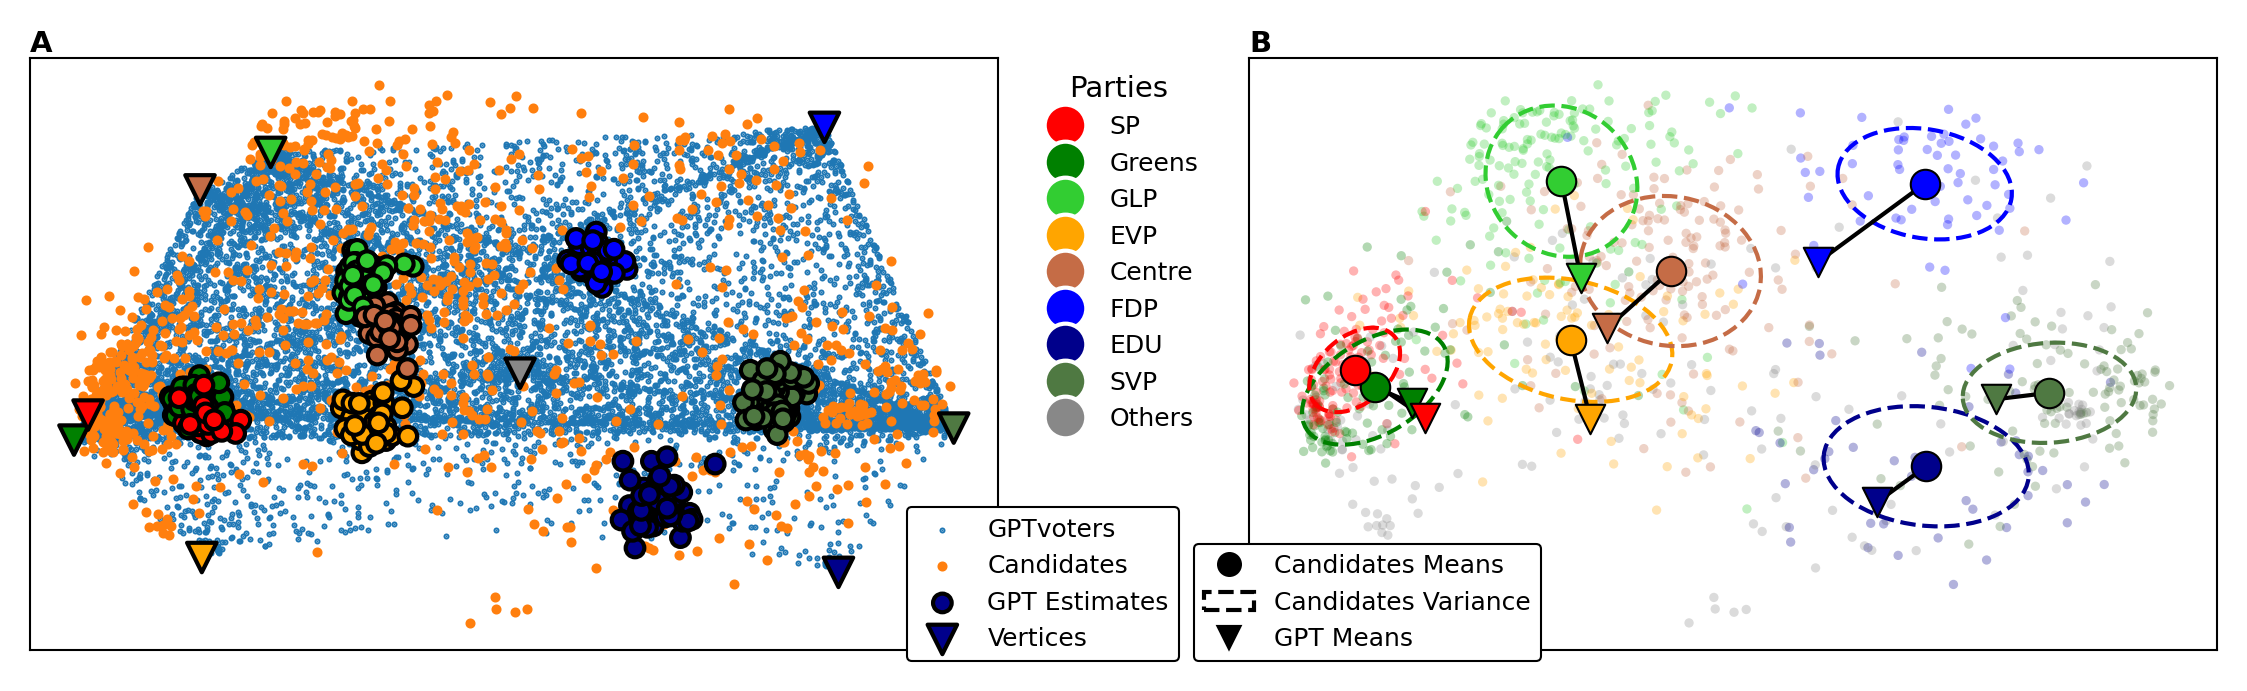

In [12]:

fig, (bx, ax) = plt.subplots(1, 2, figsize=(vis.textwidth, 0.4*vis.textwidth))
bx.set_aspect('equal')
ax.set_aspect('equal')

bx.scatter(Q.loc[:,'X'], Q.loc[:,'Y'], s=.2, lw=None, label='GPTvoters')
# bx.scatter(Q.loc[:,'X'], Q.loc[:,'Y'], s=.2, lw=None, label='GPTvoters')
bx.scatter(E.loc[:,'X'], E.loc[:,'Y'], s=2, lw=1, label='Candidates')
colors = gpt_data.index.get_level_values(0).map(vis.party_colors)
bx.scatter(P.loc[:,'X'], P.loc[:,'Y'], s=20, lw=1, c=colors, edgecolors='black',label='GPT Estimates')
colors = vertices.index.get_level_values(0).map(vis.party_colors)
bx.scatter(T.loc[:,'X'], T.loc[:,'Y'], s=50,marker='v', c=colors, label='Vertices', edgecolors='black', zorder=10)

ax.scatter(E.loc[:,'X'],E.loc[:,'Y'], c=candidates.color, s=5, edgecolor='none', alpha=0.3)
for name, data in E.groupby(level=0):
    if len(data) > 1 and name != "Übrige":
        G = GaussianDistribution().estimate(data.values)
        x_mean,y_mean = G.mean
        c = vis.party_colors.get(name, 'gray')
        ax.scatter(x_mean,y_mean, c=c, marker='o', s=50,  edgecolors='black', lw=.5, zorder=3)
        plotGaussian(G, size=0, STDS=[1], color=c, lw=1, ax=ax)
        x, y =M.loc[name]
        ax.plot([x_mean, x], [y_mean,y], c='black', lw=1)
        ax.scatter(x,y, c=c, s=50, edgecolors='black', marker='v', lw=.5 ,zorder=4, label=name)
        
# Creating custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Candidates Means',
           markerfacecolor='black', markersize=5, markeredgecolor='black', lw=0.5),
    Patch(facecolor='none', edgecolor='black', label='Candidates Variance', linestyle='--', lw=1),
    Line2D([0], [0], marker='v', color='w', label='GPT Means',
           markerfacecolor='black', markersize=5, markeredgecolor='black', lw=0.5)
]

# Party colors
legend_elements_1 = [Line2D([0], [0], marker='o', color='w', label=val, markersize=10, markerfacecolor=vis.party_colors[key]) for key, val in vis.party_names.items()]

leg_offset = 0.06
# Creating the legend with two columns
leg1 = bx.legend(handles=legend_elements_1, loc='upper left', bbox_to_anchor=(1.02, 1.01), title='Parties', ncol=1, frameon=False)
leg2 = ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(-.13+leg_offset,-.04), ncol=1)

# Create first legend
bx.add_artist(leg1)  # Add the first legend manually
# leg2 = bx.legend(loc='center', bbox_to_anchor=(.5, -.07), ncol=1, borderaxespad=0.)
leg3 = bx.legend(loc='lower right', bbox_to_anchor=(1.14+leg_offset,-.04), ncol=1)

for leg in (leg1, leg2, leg3):
    leg.get_frame().set_edgecolor('black')  # Border color
    leg.get_frame().set_linewidth(.5)        # Border thickness
    leg.get_frame().set_facecolor('white')  # Set background color to white (or any solid color)
    leg.get_frame().set_alpha(1)            # Background opacity set to 1 (opaque)

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=bx.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax.transAxes)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
bx.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

ax.set_xlim(bx.get_xlim())
ax.set_ylim(bx.get_ylim())

fig.tight_layout()
plt.subplots_adjust(wspace=.26)
vis.savefig(fig, 'GPT_Vertices_PCA', save_figures)

# Print the size of the figure
print("Figure size in inches:", fig.get_size_inches()/vis.inches_pt)
print("Aspect ratio of the figure:", fig.get_figheight()/fig.get_figwidth())


Figure size in inches: [542.025 216.81 ]
Aspect ratio of the figure: 0.4


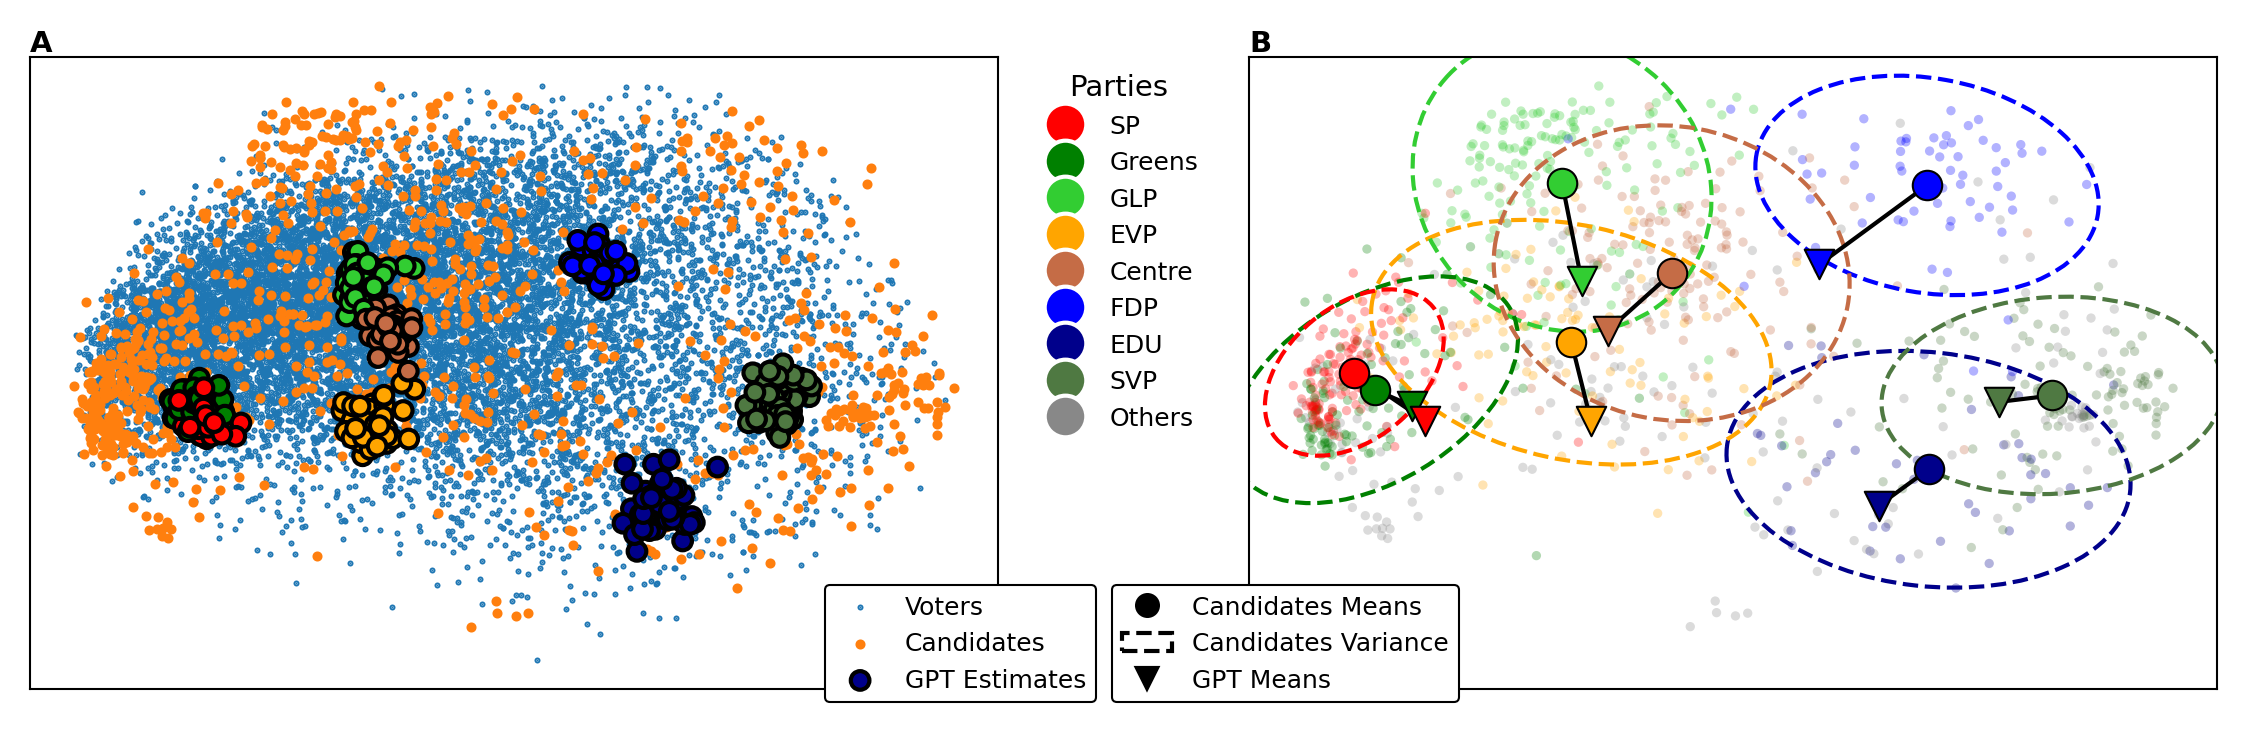

In [14]:
fig, (bx, ax) = plt.subplots(1, 2, figsize=(vis.textwidth, 0.4*vis.textwidth))
bx.set_aspect('equal')
ax.set_aspect('equal')

bx.scatter(V.loc[:,'X'], V.loc[:,'Y'], s=.2, lw=None, label='Voters')
# bx.scatter(Q.loc[:,'X'], Q.loc[:,'Y'], s=.2, lw=None, label='GPTvoters')
bx.scatter(E.loc[:,'X'], E.loc[:,'Y'], s=2, lw=1, label='Candidates')
colors = gpt_data.index.get_level_values(0).map(vis.party_colors)
bx.scatter(P.loc[:,'X'], P.loc[:,'Y'], s=20, lw=1, c=colors, edgecolors='black',label='GPT Estimates')

ax.scatter(E.loc[:,'X'],E.loc[:,'Y'], c=candidates.color, s=5, edgecolor='none', alpha=0.3)
for name, data in E.groupby(level=0):
    if len(data) > 1 and name != "Übrige":
        G = GaussianDistribution().estimate(data.values)
        x_mean,y_mean = G.mean
        c = vis.party_colors.get(name, 'gray')
        ax.scatter(x_mean,y_mean, c=c, marker='o', s=50,  edgecolors='black', lw=.5, zorder=3)
        plotGaussian(G, size=0, STDS=[1.96], color=c, lw=1, ax=ax)
        x, y =M.loc[name]
        ax.plot([x_mean, x], [y_mean,y], c='black', lw=1)
        ax.scatter(x,y, c=c, s=50, edgecolors='black', marker='v', lw=.5 ,zorder=4, label=name)
        
# Creating custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Candidates Means',
           markerfacecolor='black', markersize=5, markeredgecolor='black', lw=0.5),
    Patch(facecolor='none', edgecolor='black', label='Candidates Variance', linestyle='--', lw=1),
    Line2D([0], [0], marker='v', color='w', label='GPT Means',
           markerfacecolor='black', markersize=5, markeredgecolor='black', lw=0.5)
]

# Party colors
legend_elements_1 = [Line2D([0], [0], marker='o', color='w', label=val, markersize=10, markerfacecolor=vis.party_colors[key]) for key, val in vis.party_names.items()]

leg_offset = -0.025
# Creating the legend with two columns
leg1 = bx.legend(handles=legend_elements_1, loc='upper left', bbox_to_anchor=(1.02, 1.01), title='Parties', ncol=1, frameon=False)
leg2 = ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(-.13+leg_offset,-.04), ncol=1)

# Create first legend
bx.add_artist(leg1)  # Add the first legend manually
# leg2 = bx.legend(loc='center', bbox_to_anchor=(.5, -.07), ncol=1, borderaxespad=0.)
leg3 = bx.legend(loc='lower right', bbox_to_anchor=(1.14+leg_offset,-.04), ncol=1)

for leg in (leg1, leg2, leg3):
    leg.get_frame().set_edgecolor('black')  # Border color
    leg.get_frame().set_linewidth(.5)        # Border thickness
    leg.get_frame().set_facecolor('white')  # Set background color to white (or any solid color)
    leg.get_frame().set_alpha(1)            # Background opacity set to 1 (opaque)

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=bx.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax.transAxes)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
bx.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

ax.set_xlim(bx.get_xlim())
ax.set_ylim(bx.get_ylim())

fig.tight_layout()
plt.subplots_adjust(wspace=.26)
vis.savefig(fig, 'GPT_Voters_PCA', save_figures)

# Print the size of the figure
print("Figure size in inches:", fig.get_size_inches()/vis.inches_pt)
print("Aspect ratio of the figure:", fig.get_figheight()/fig.get_figwidth())
